# Project 1: CO2 levels prediction at Mauna Loa Observatory

 Monthly average CO2 at Mauna Loa Observatory, Hawaii, U.S.A.

 https://gml.noaa.gov/ccgg/trends/index.html


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
# Importing libraries
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

from pylab import rcParams

import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error

from plotly import tools

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/open?id=1OuHUoP1yZ6oGY_AbjGGmHvjmTcXoDKn3'

In [4]:
fluff, id = link.split('=')
file = drive.CreateFile({'id':id}) 
print(file)
file.GetContentFile('co2.csv') 
Co2_df  = pd.read_csv('co2.csv', parse_dates=['date'], index_col='date')
Co2_df.head()

GoogleDriveFile({'id': '1OuHUoP1yZ6oGY_AbjGGmHvjmTcXoDKn3'})


,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


missing data:  co2    59
dtype: int64


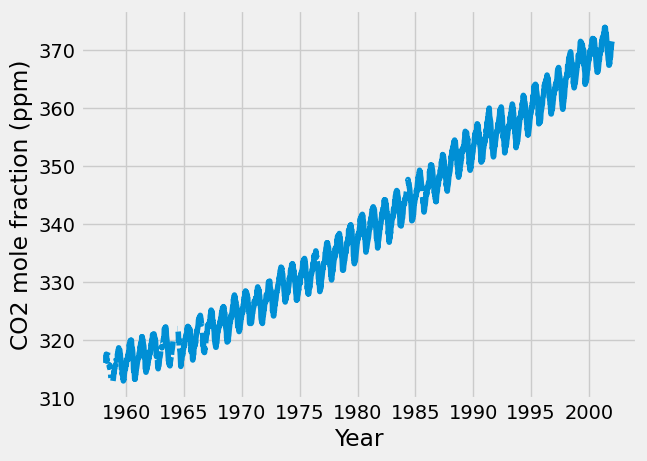

In [5]:
plt.xlabel('Year')
plt.ylabel('CO2 mole fraction (ppm)')
plt.plot(Co2_df)
print("missing data: ", Co2_df.isnull().sum())

In [6]:
Co2_df 
y = Co2_df['co2'].resample('MS').mean()
y.isnull().sum()

5

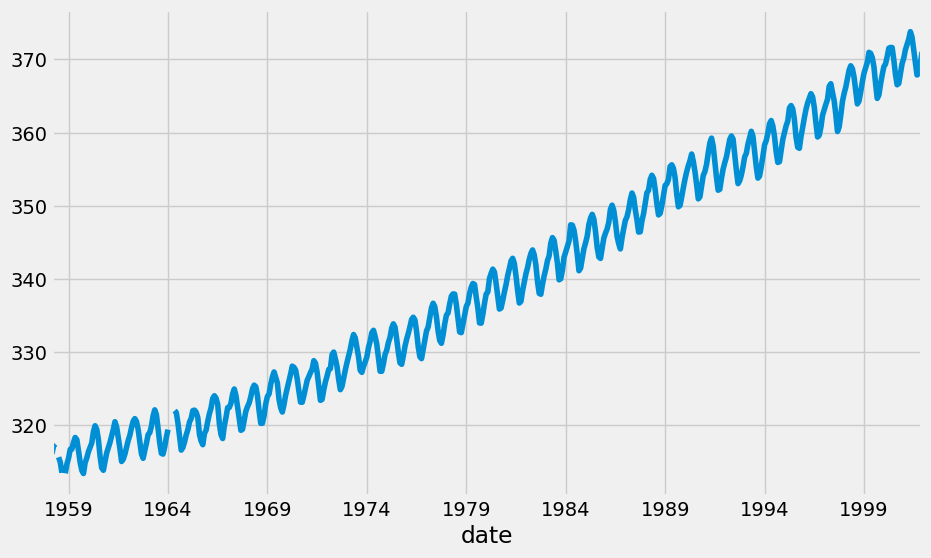

In [7]:
y.plot(figsize=(10, 6))
plt.show()

In [8]:
y.head()

date
1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01           NaN
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

In [9]:
type(y)

pandas.core.series.Series

In [10]:

y.describe()

count    521.000000
mean     339.822665
std       17.068711
min      313.400000
25%      324.125000
50%      337.950000
75%      354.675000
max      373.800000
Name: co2, dtype: float64

In [11]:
y.index

DatetimeIndex(['1958-03-01', '1958-04-01', '1958-05-01', '1958-06-01',
               '1958-07-01', '1958-08-01', '1958-09-01', '1958-10-01',
               '1958-11-01', '1958-12-01',
               ...
               '2001-03-01', '2001-04-01', '2001-05-01', '2001-06-01',
               '2001-07-01', '2001-08-01', '2001-09-01', '2001-10-01',
               '2001-11-01', '2001-12-01'],
              dtype='datetime64[ns]', name='date', length=526, freq='MS')

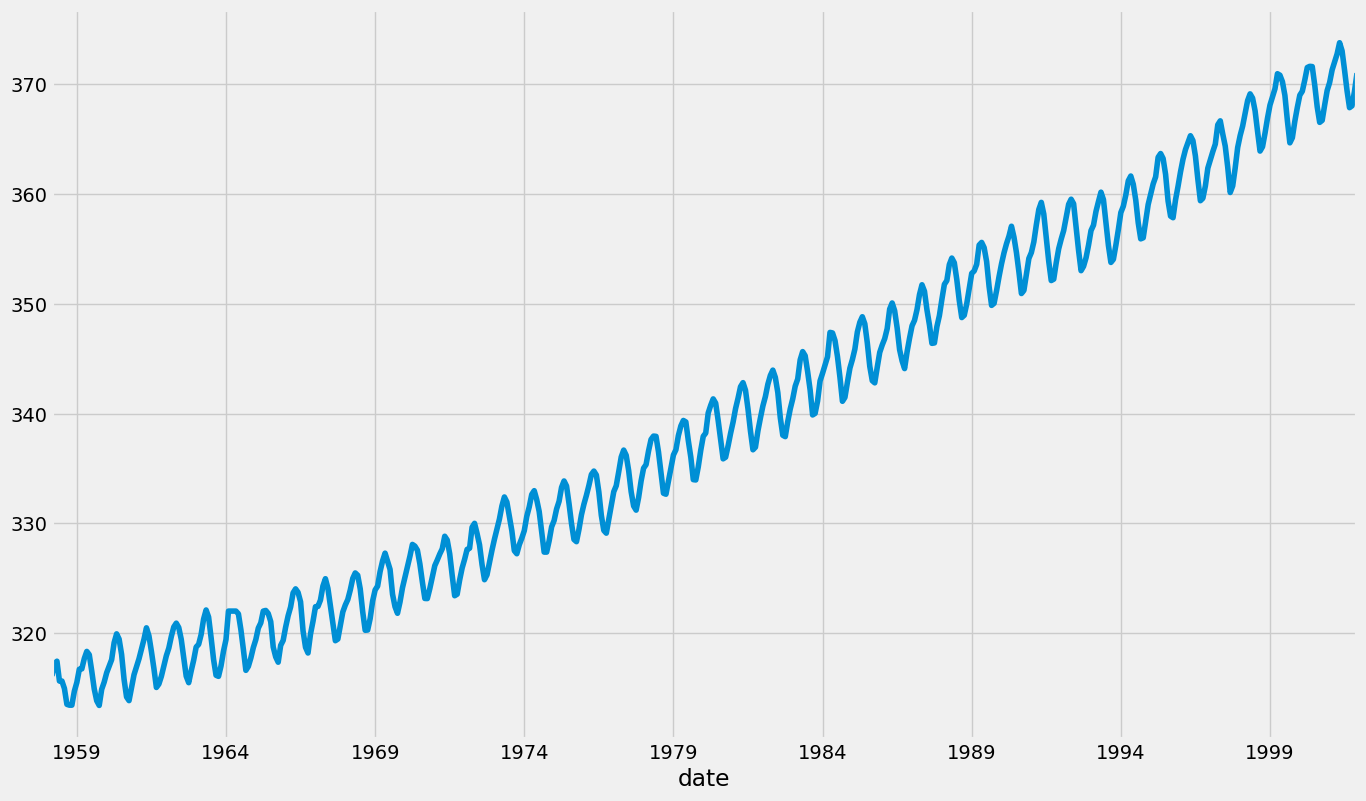

In [12]:
y = y.fillna(y.bfill())

y.plot(figsize=(15,9))
plt.show()

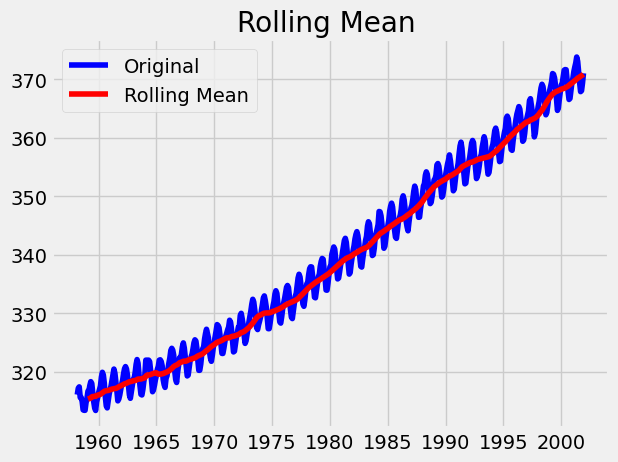

In [13]:

rollingmean = y.rolling(window=12).mean()
rollingstd = y.rolling(window=12).std()

orig = plt.plot(y, color='blue', label='Original')
mean = plt.plot(rollingmean , color='red', label='Rolling Mean')
#std = plt.plot(rollingstd, color='black', label='Rolling Std')
plt.rcParams["figure.figsize"] = (30,9)

plt.legend(loc='best')
plt.title('Rolling Mean ')
plt.show(block=False)


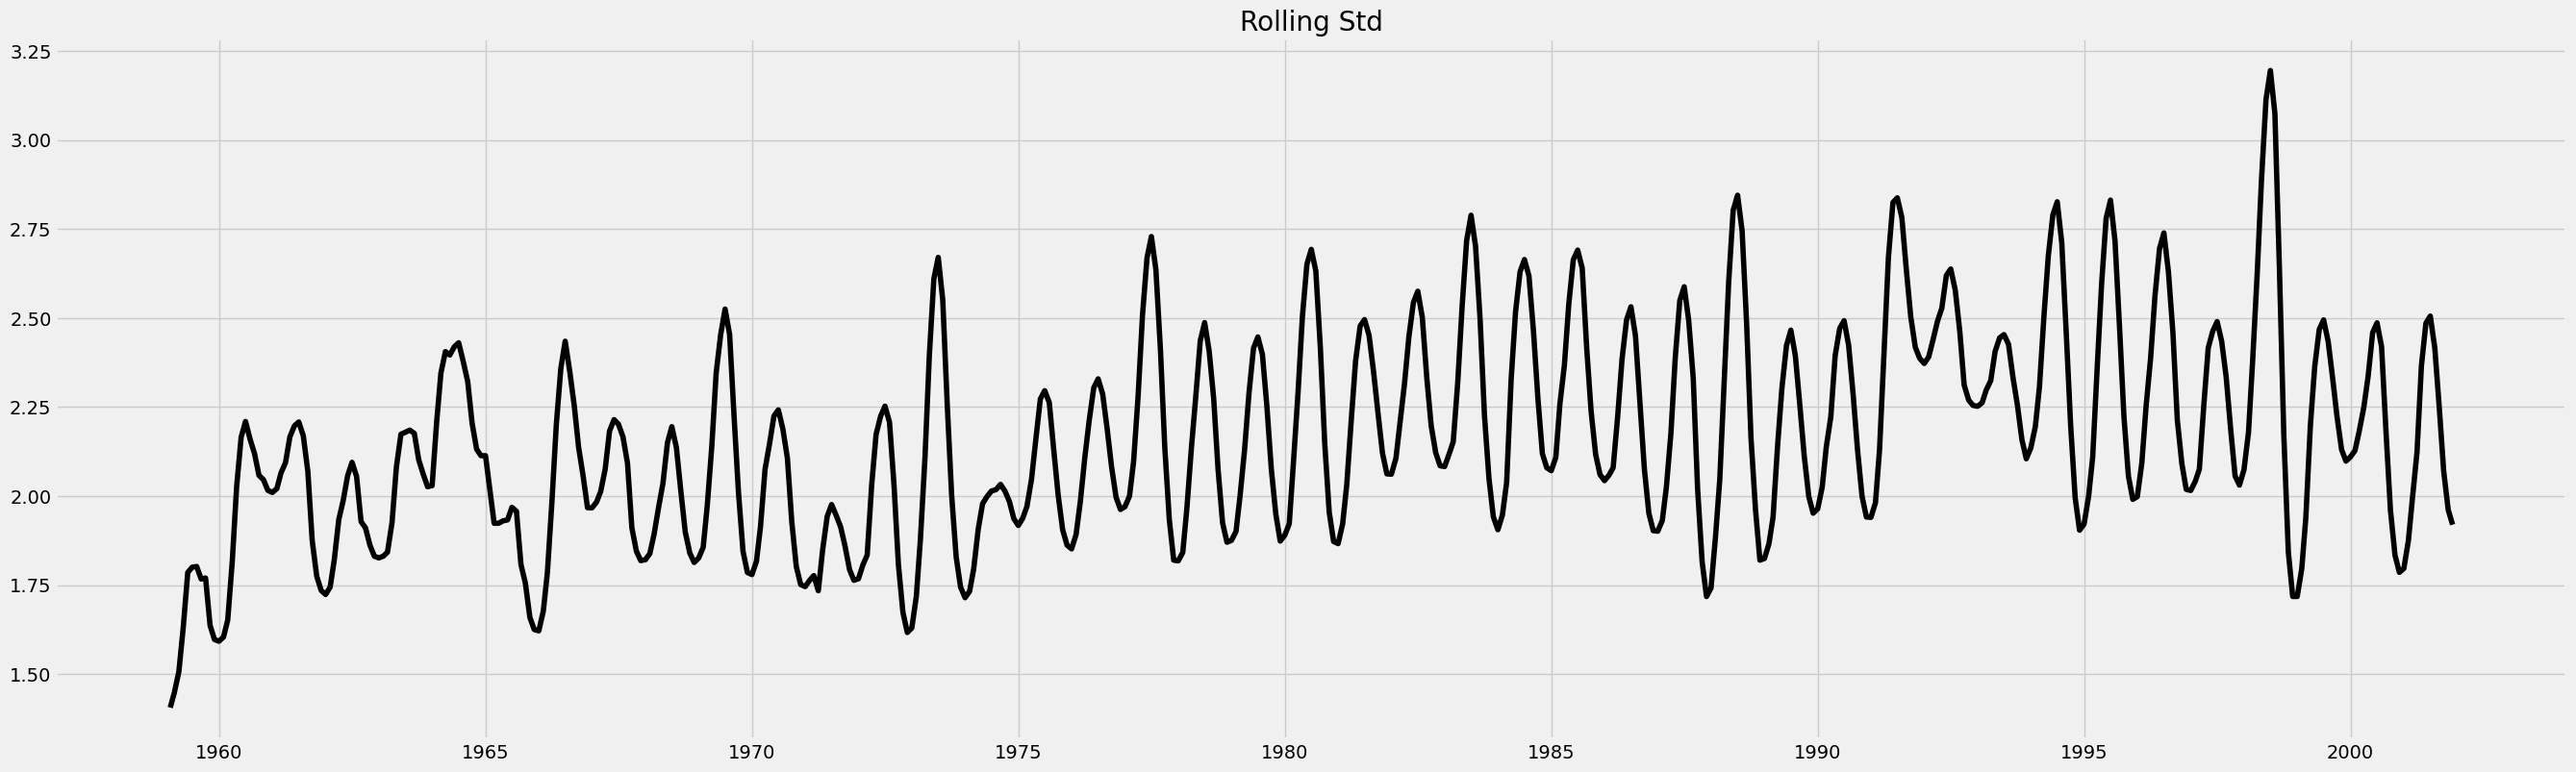

In [14]:
std = plt.plot(rollingstd, color='black', label='Rolling Std')
plt.title('Rolling Std')
plt.show(block=False)



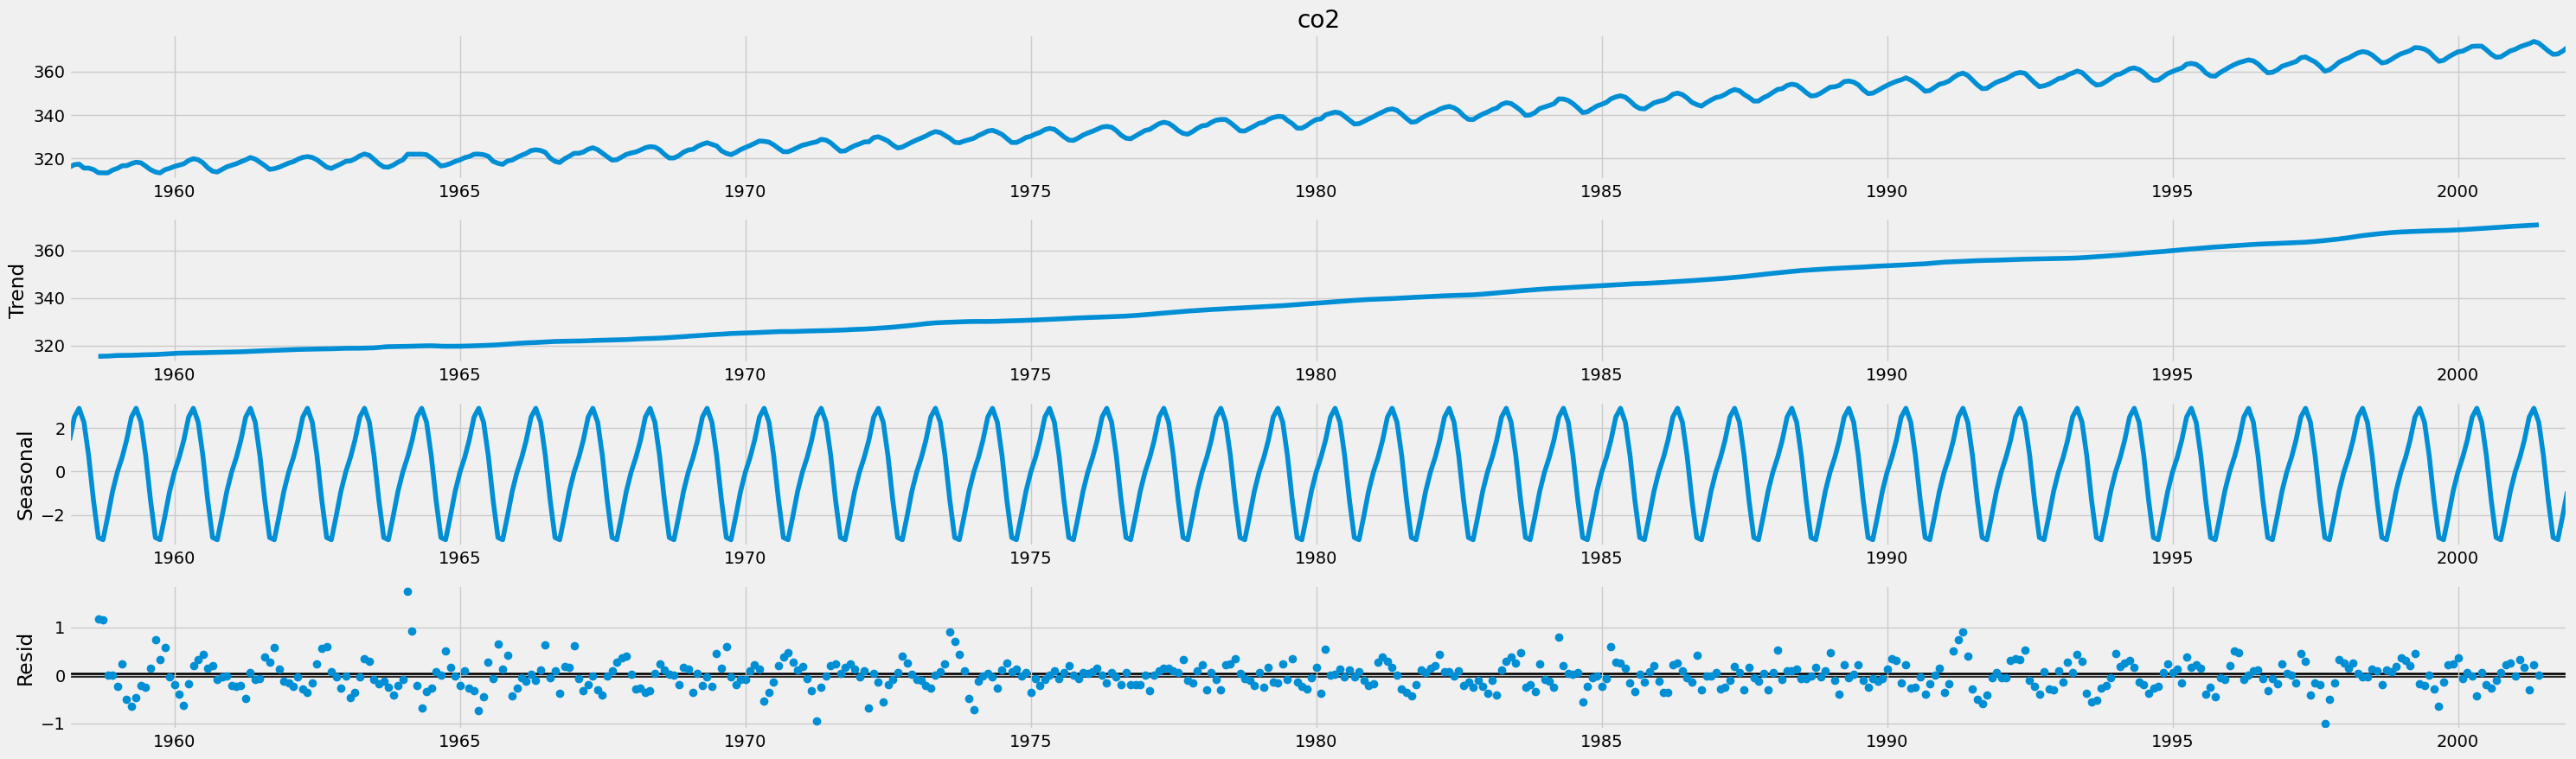

In [15]:
deco = sm.tsa.seasonal_decompose(y, model='additive')
fig = deco.plot()
plt.rcParams["figure.figsize"] = (30,10)

plt.show()

In [16]:
deco.resid.describe()

count    514.000000
mean       0.002790
std        0.298683
min       -0.997063
25%       -0.195065
50%       -0.008551
75%        0.166299
max        1.745334
Name: resid, dtype: float64

In [17]:
deco.resid.isnull().sum()

12

In [18]:
CO2Residual = deco.resid
CO2Residual = CO2Residual.fillna(CO2Residual.bfill())
CO2Residual = CO2Residual.fillna(CO2Residual.ffill())

In [19]:
CO2Residual.describe()

count    526.000000
mean       0.016137
std        0.320423
min       -0.997063
25%       -0.192372
50%       -0.000486
75%        0.169395
max        1.745334
Name: resid, dtype: float64

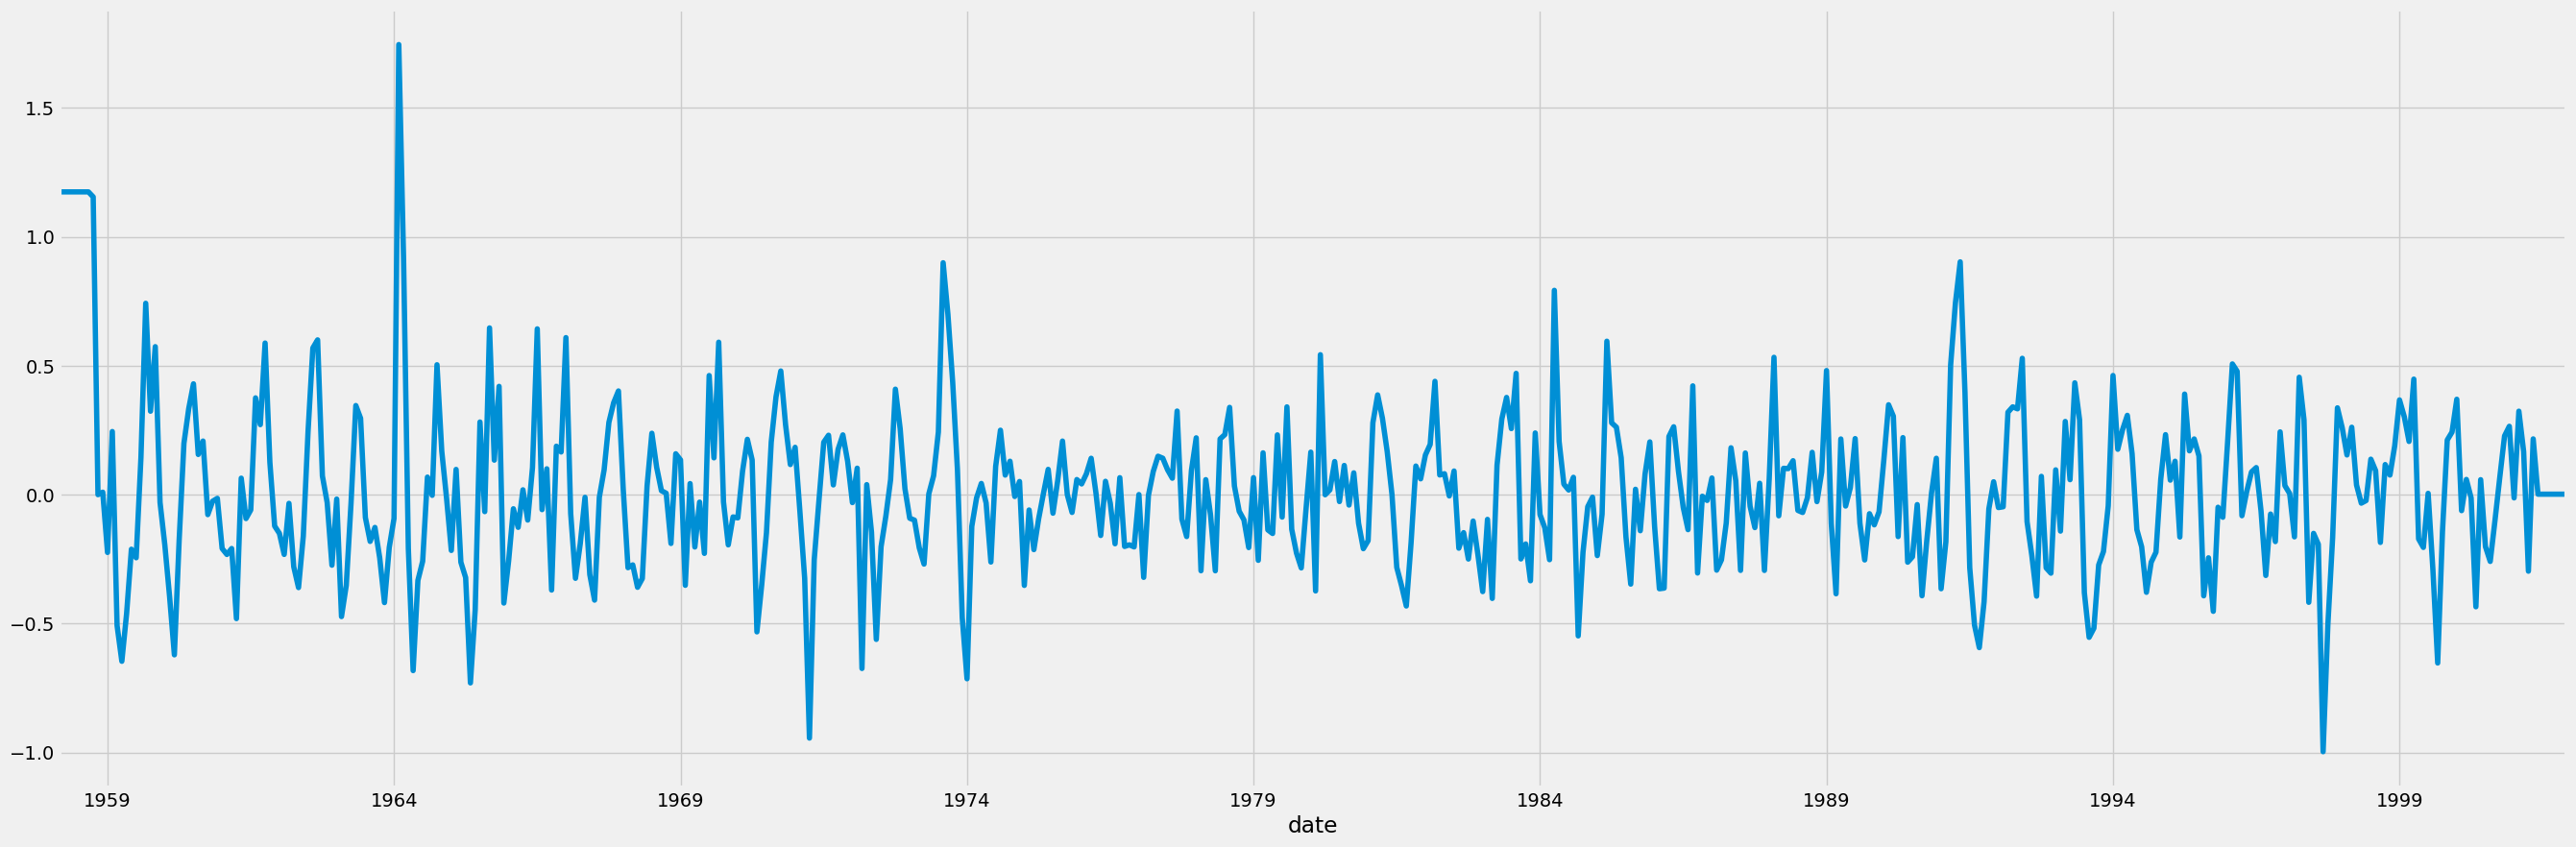

In [20]:
fig = CO2Residual.plot()
plt.show()

In [21]:
ADFresult = adfuller(CO2Residual)

In [22]:
print('ADF Statistic: %f' % ADFresult[0])
print('p-value: %f' % ADFresult[1])
print('Critical Values:')
for key, value in ADFresult[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -12.181866
p-value: 0.000000
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


In [23]:
CO2trend = deco.trend
CO2trend = CO2trend.fillna(CO2trend.bfill())
CO2trend = CO2trend.fillna(CO2trend.ffill())
#CO2trend.isnull().sum()
CO2trend

date
1958-03-01    315.375000
1958-04-01    315.375000
1958-05-01    315.375000
1958-06-01    315.375000
1958-07-01    315.375000
                 ...    
2001-08-01    370.787917
2001-09-01    370.787917
2001-10-01    370.787917
2001-11-01    370.787917
2001-12-01    370.787917
Freq: MS, Name: trend, Length: 526, dtype: float64

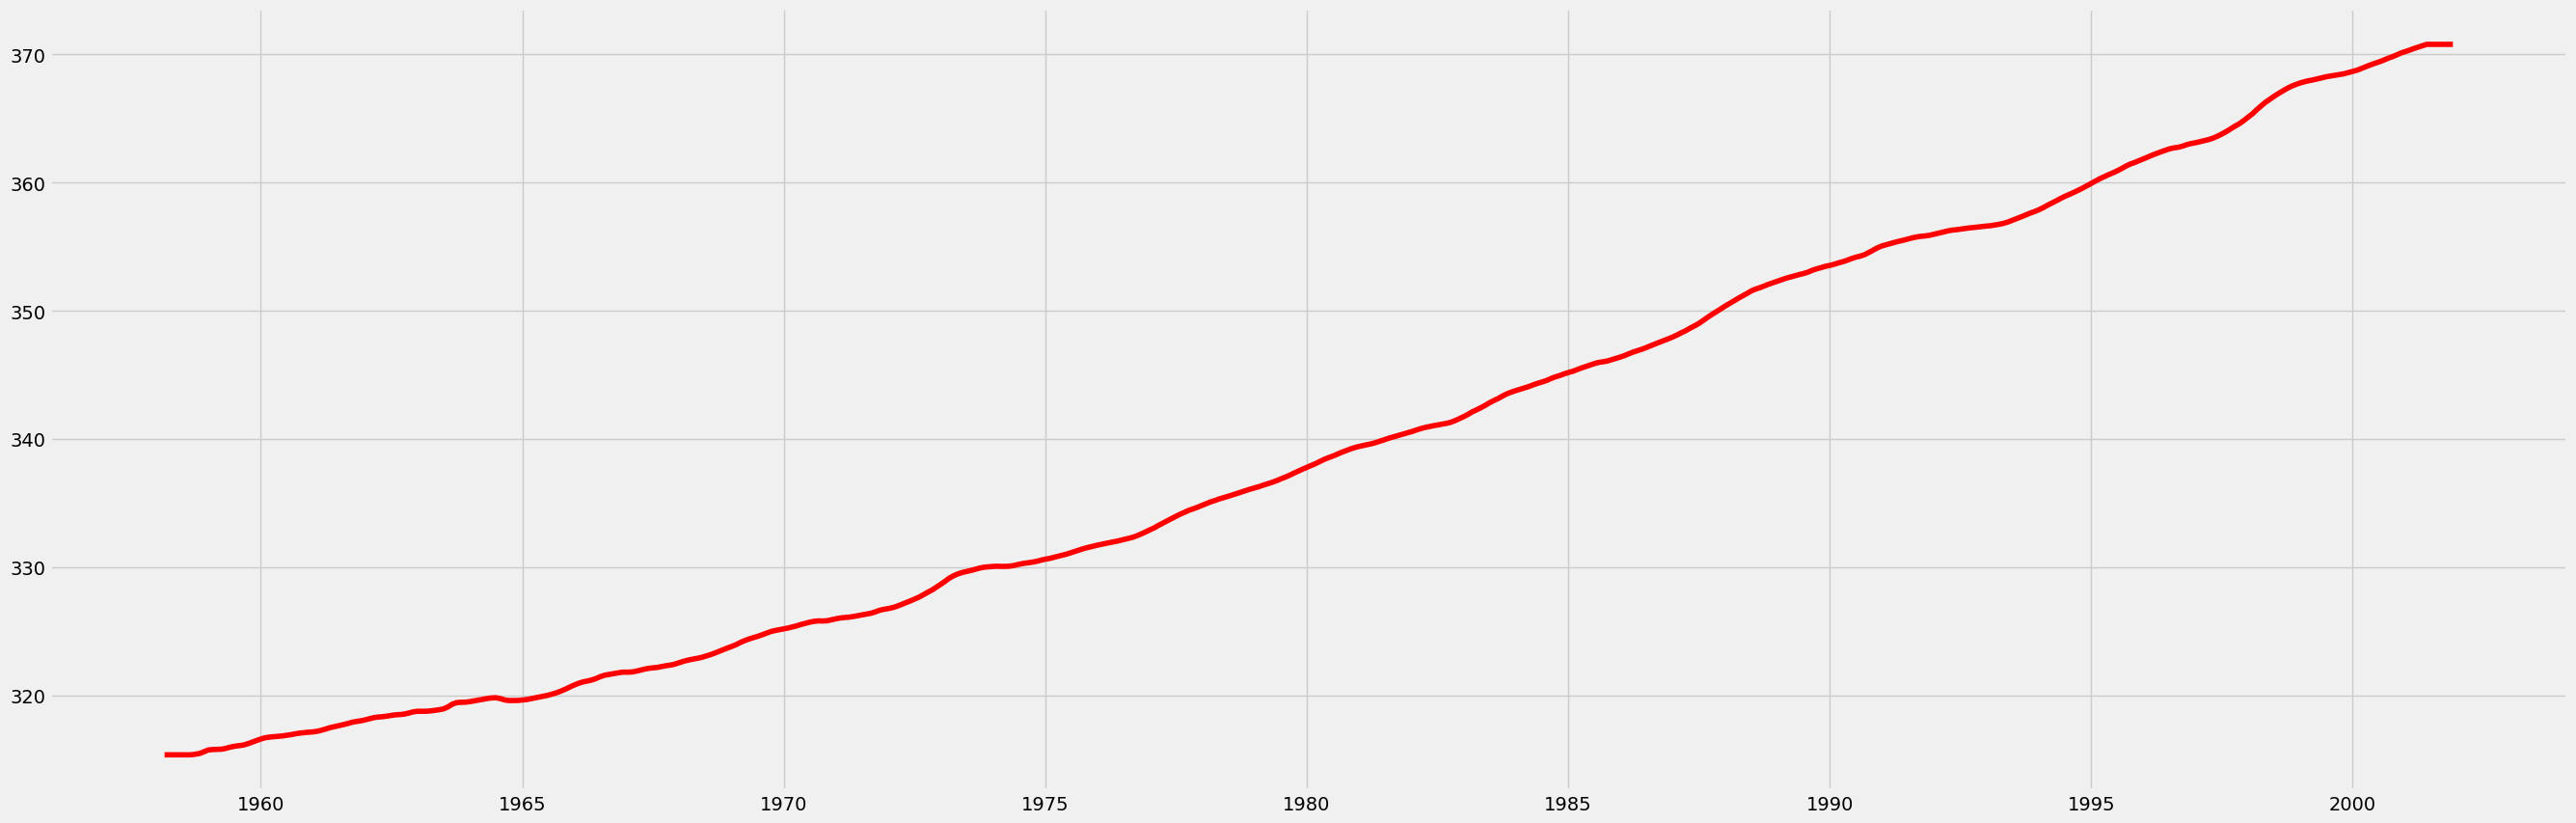

In [24]:
mean = plt.plot(CO2trend , color='red', label='CO2trend')

In [25]:
ADFresult = adfuller(CO2trend)

In [26]:
print('ADF Statistic: %f' % ADFresult[0])
print('p-value: %f' % ADFresult[1])
print('Critical Values:')
for key, value in ADFresult[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 1.761347
p-value: 0.998269
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


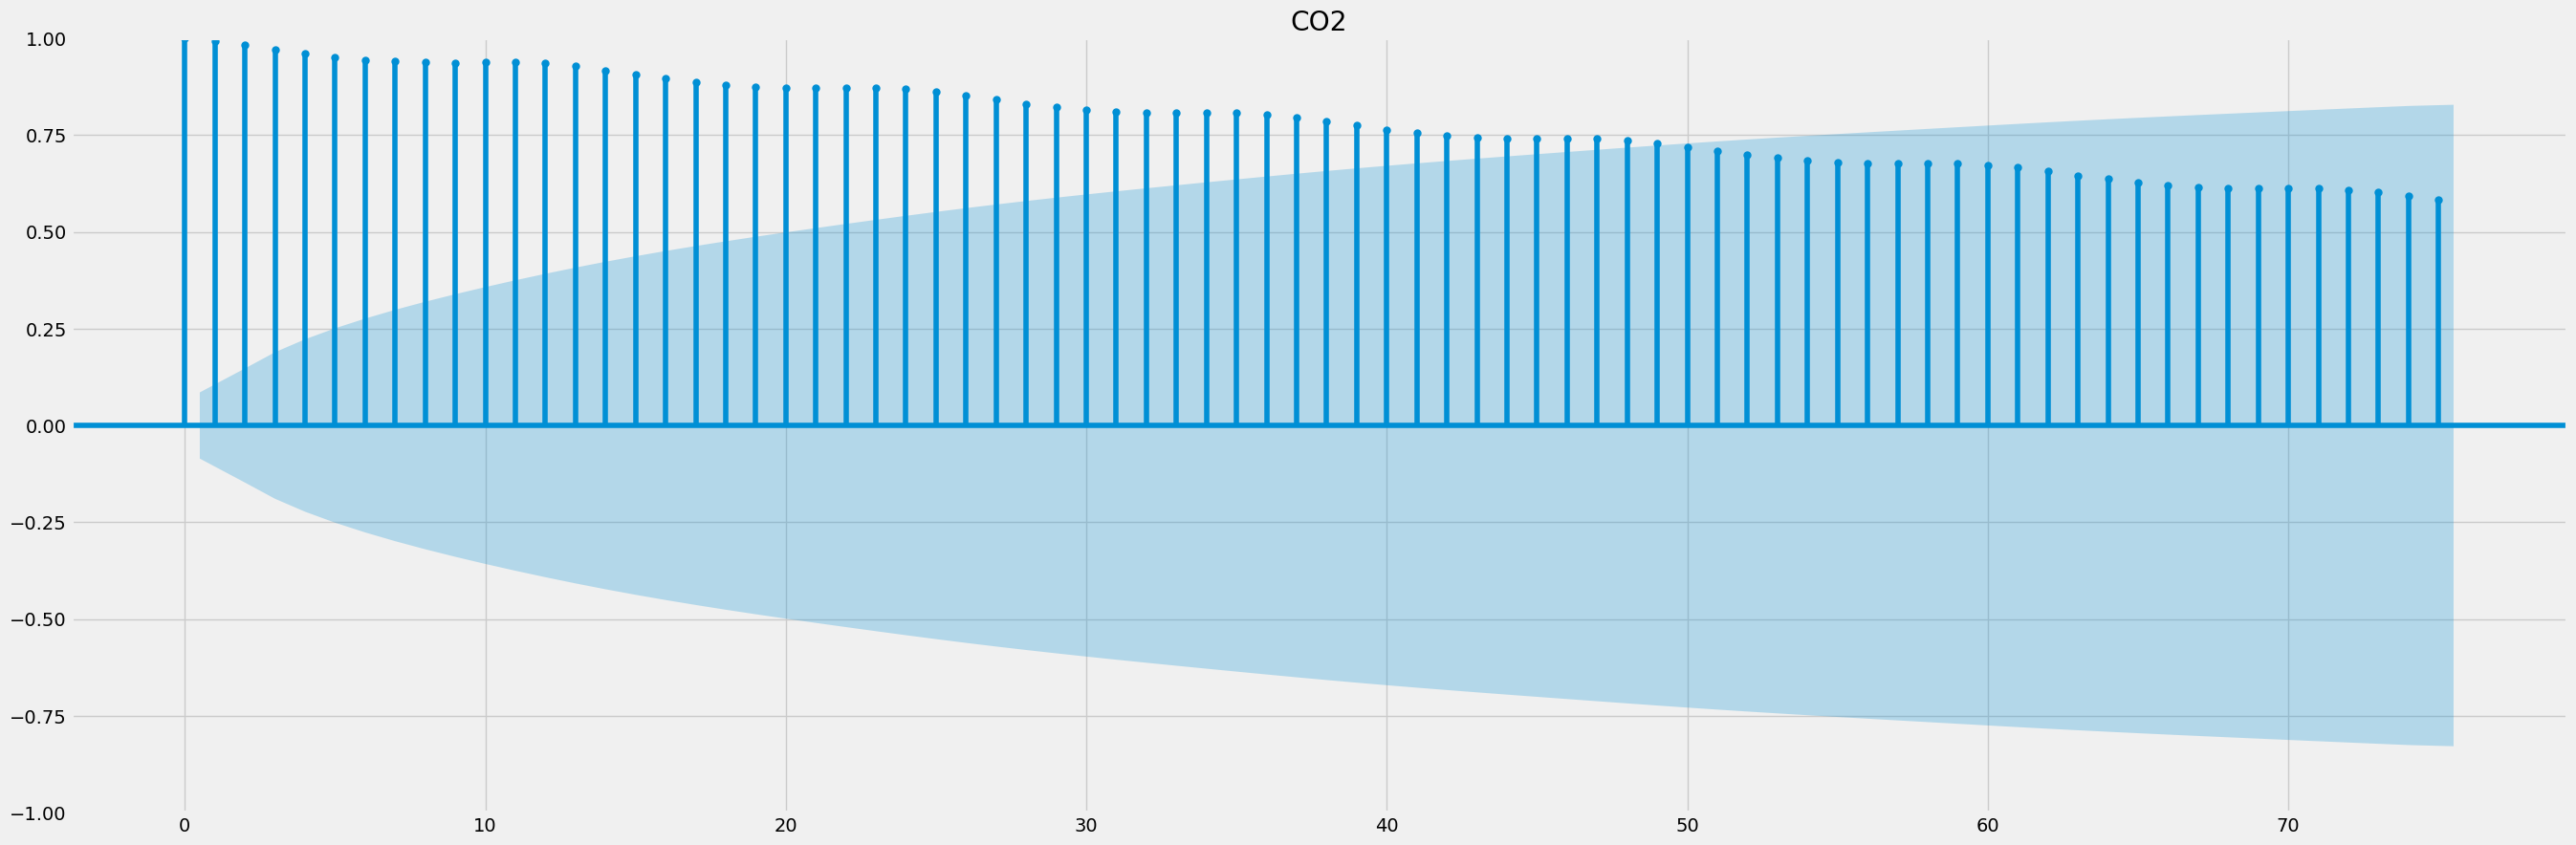

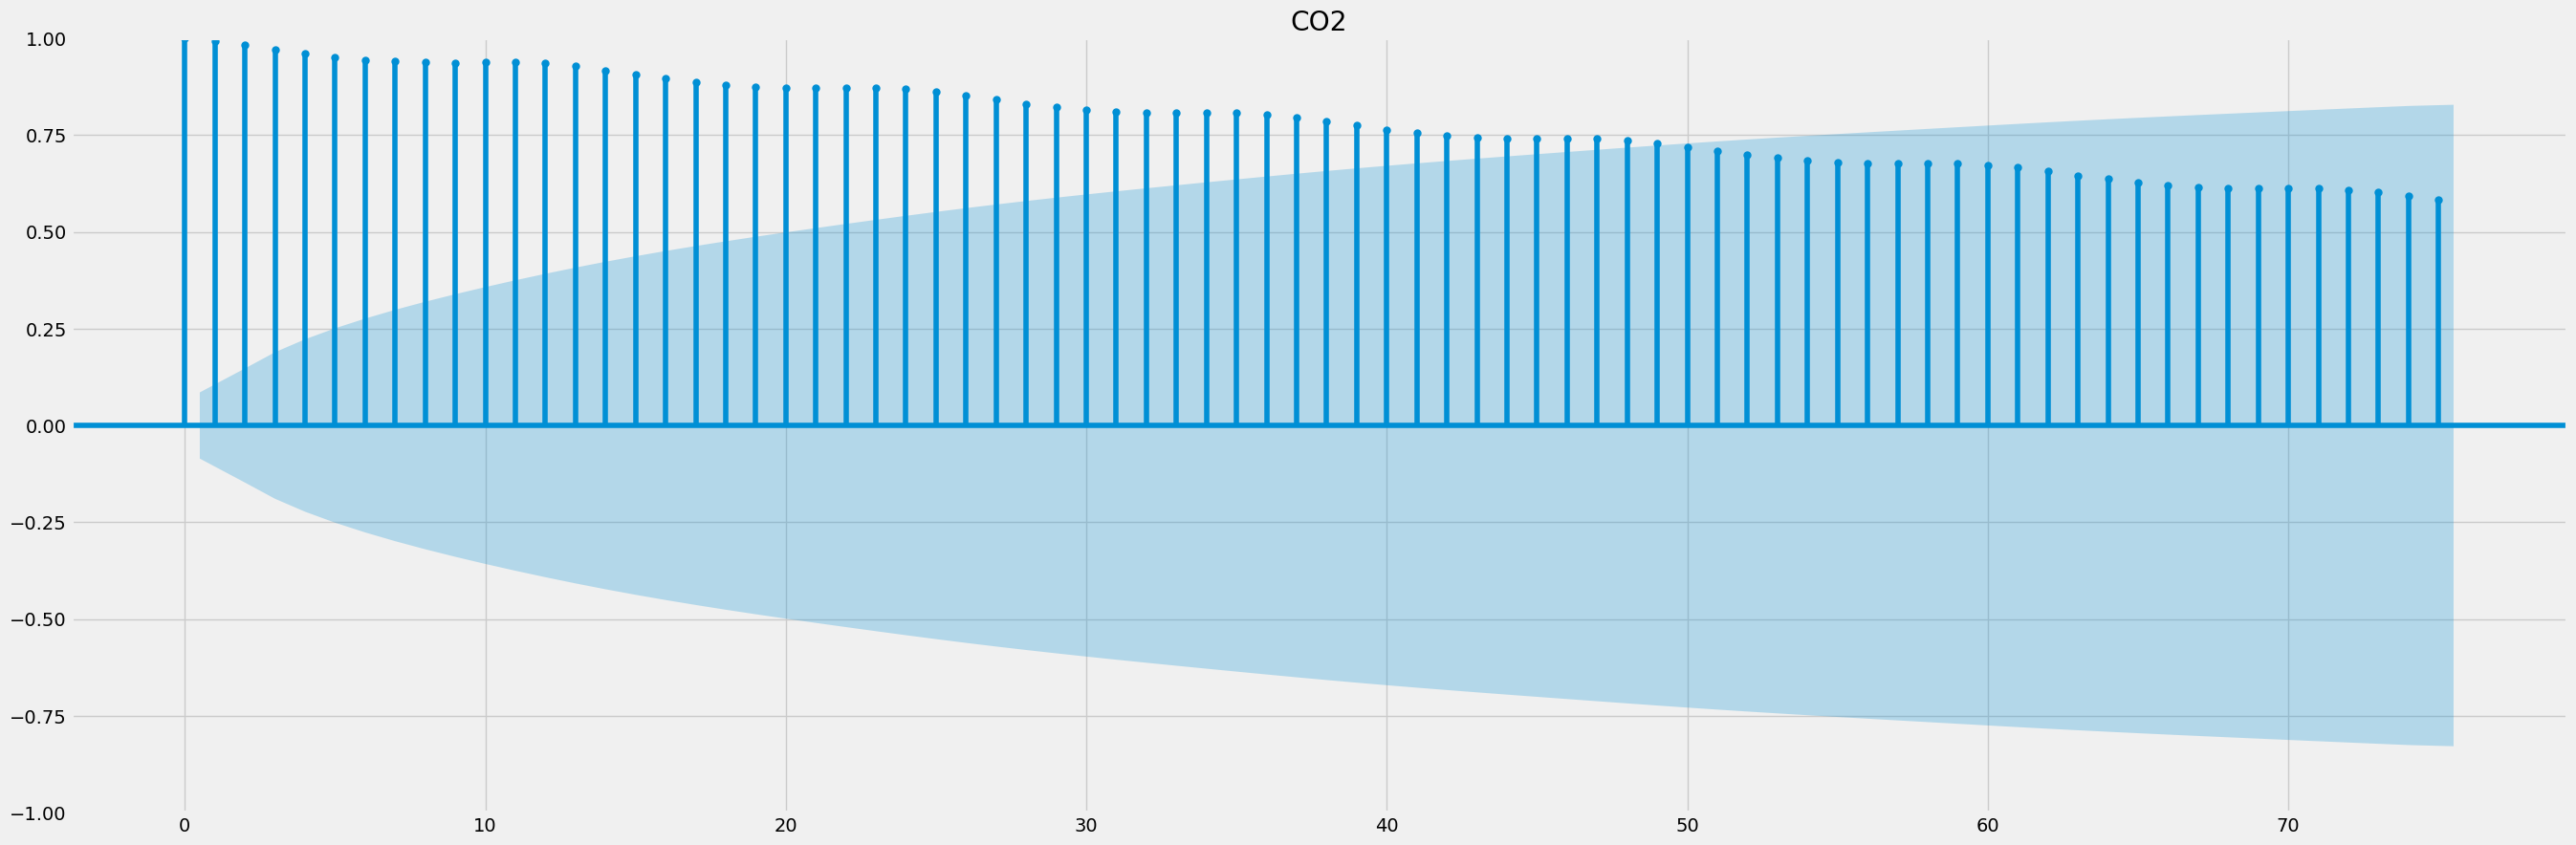

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#plot_acf(CO2Residual,title="CO2")
plot_acf(y,lags=75,title="CO2")

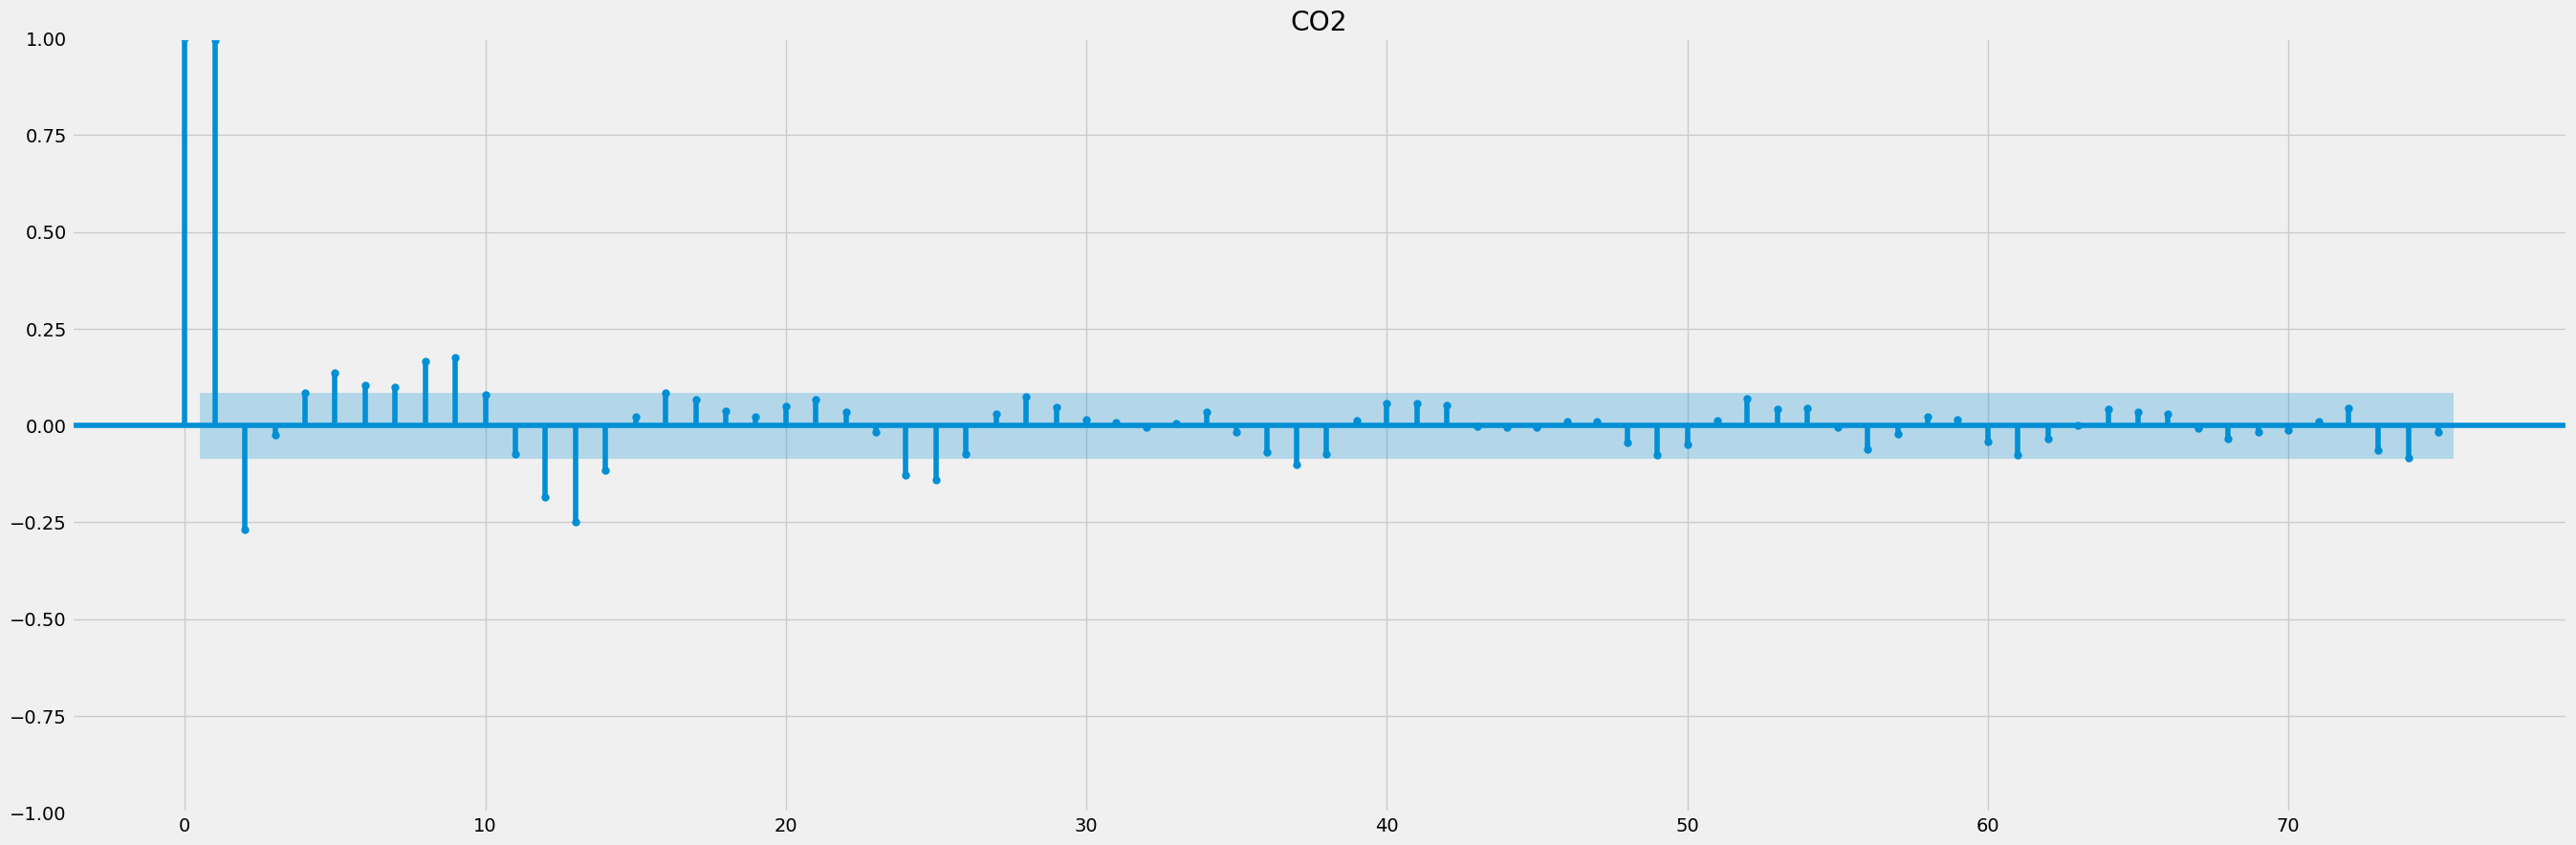

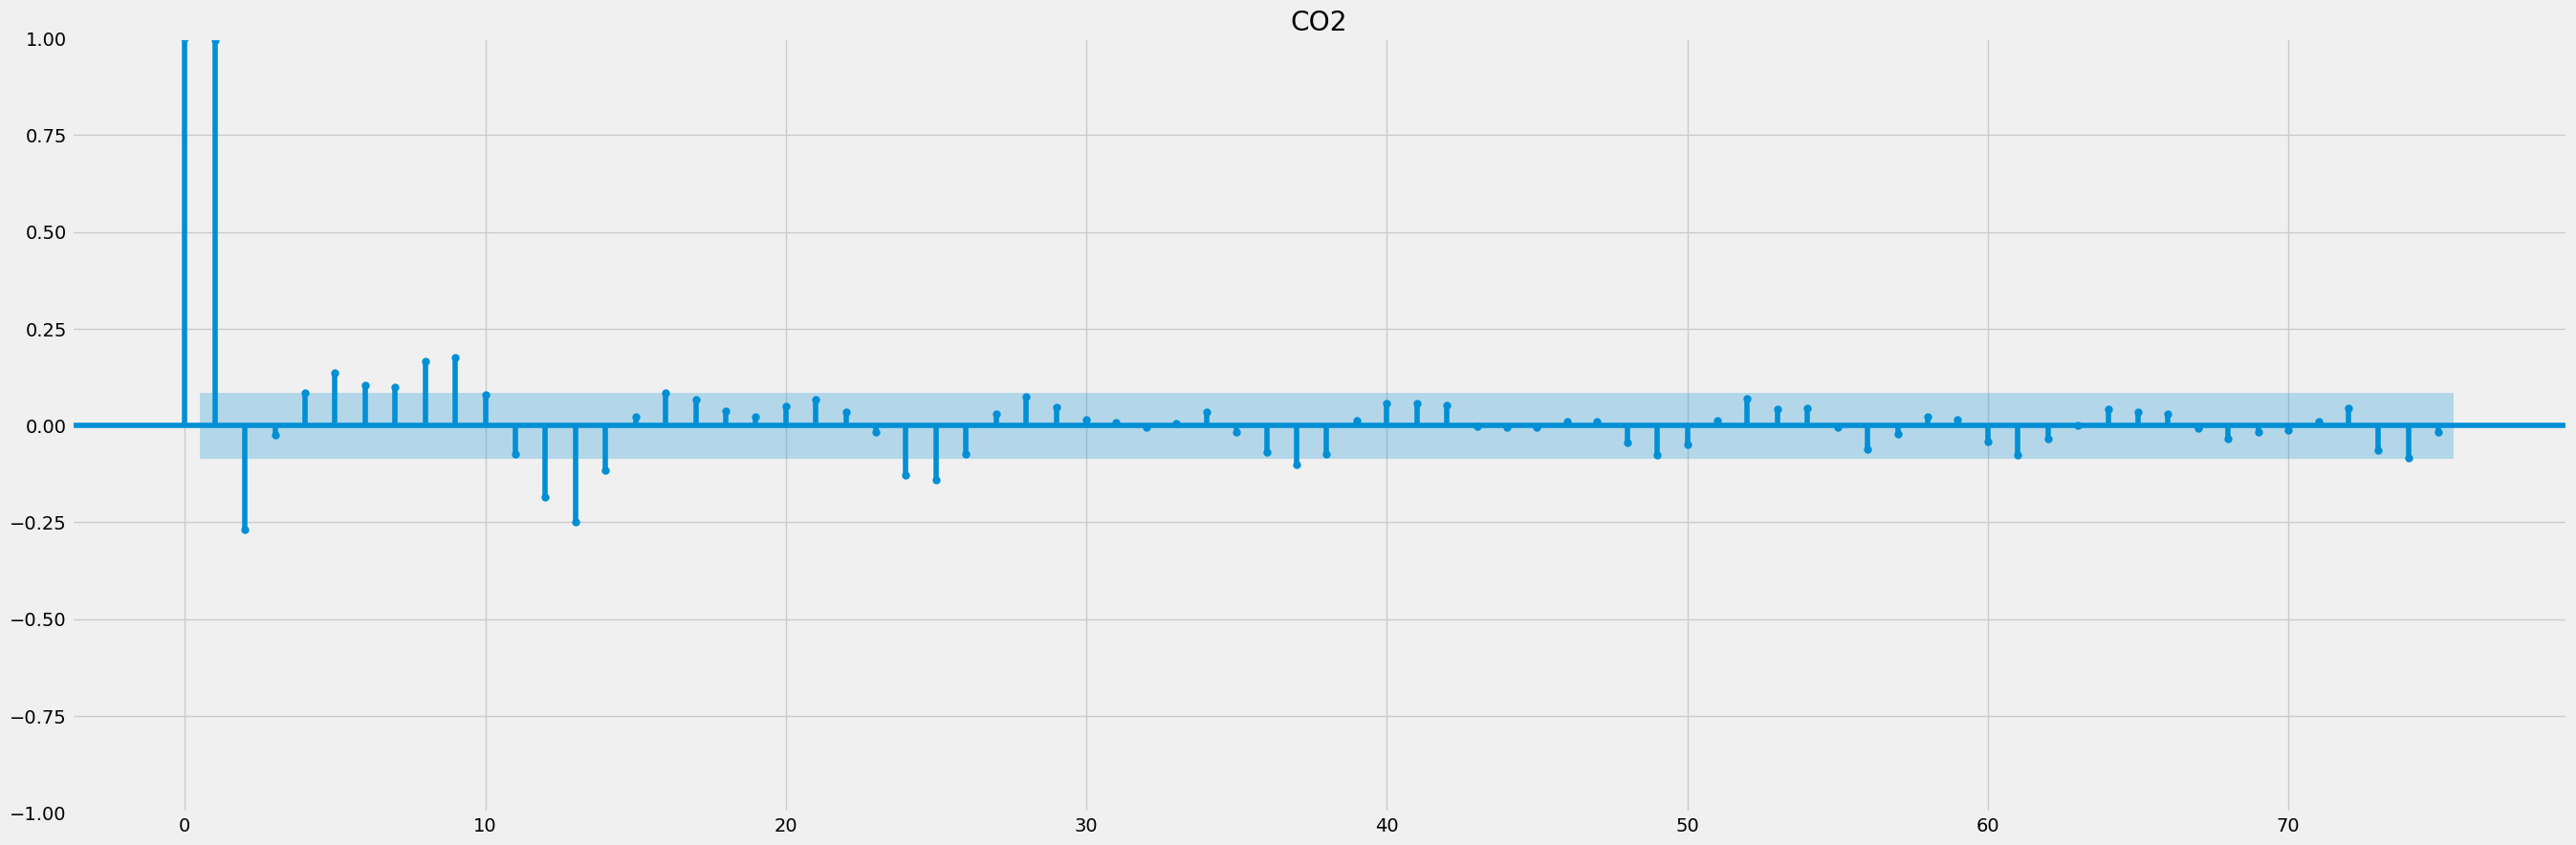

In [28]:
#plot_pacf(CO2Residual,title="CO2")
plot_pacf(y,lags=75,title="CO2")

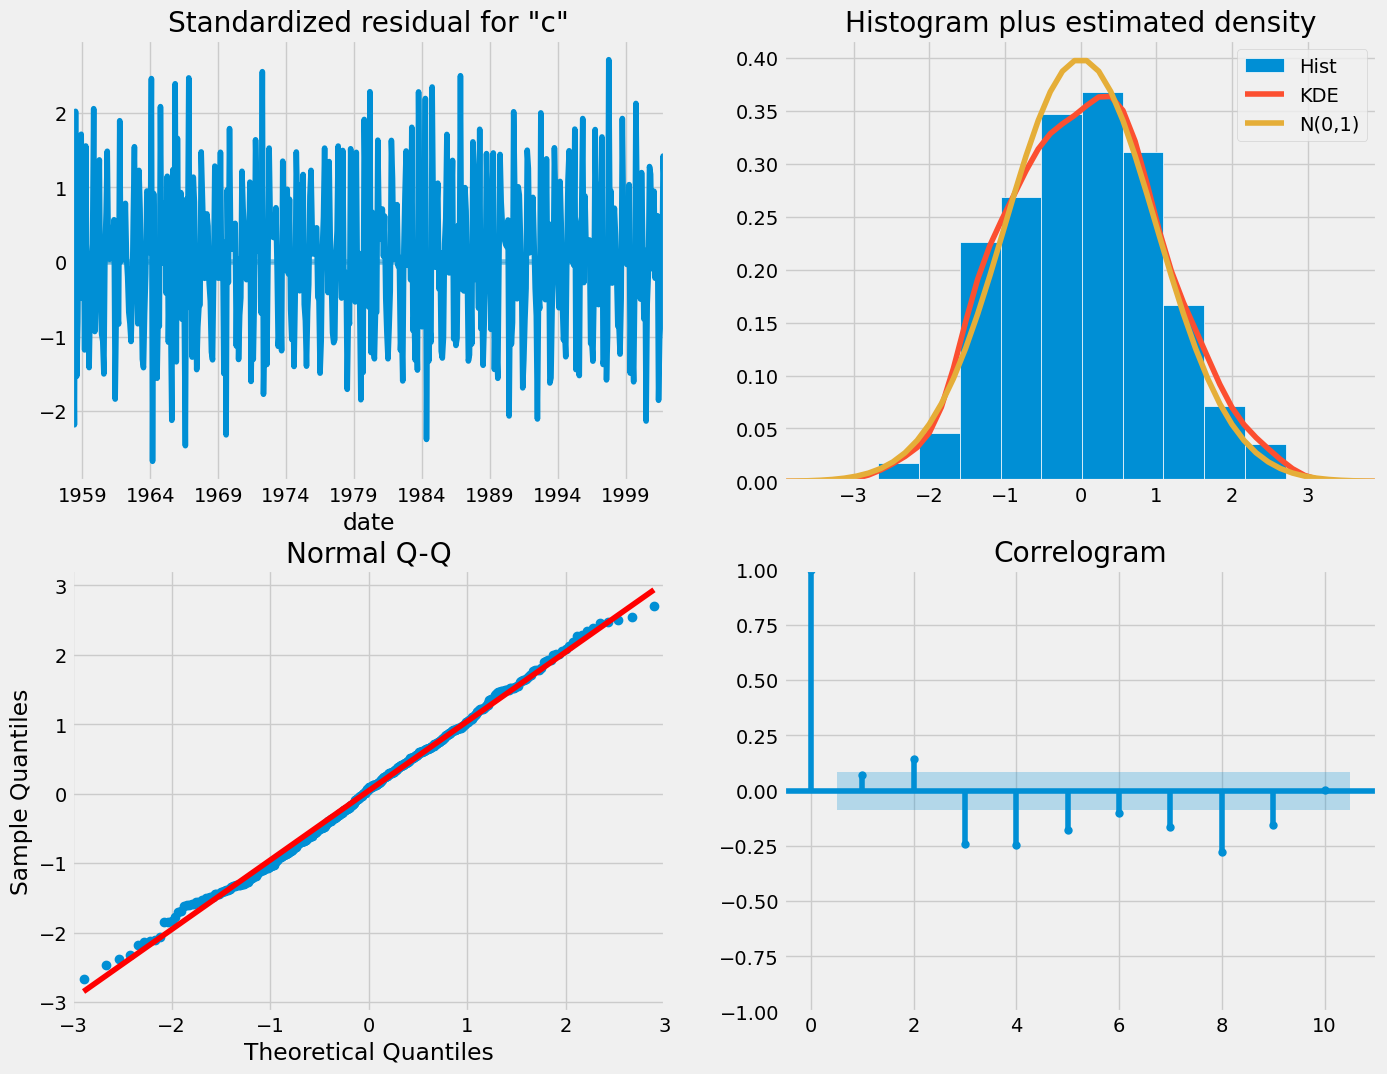

In [29]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
				)

TSresults = mod.fit()

#print(TSresults.summary().tables[1])

TSresults.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
y

date
1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
                 ...    
2001-08-01    369.425000
2001-09-01    367.880000
2001-10-01    368.050000
2001-11-01    369.375000
2001-12-01    371.020000
Freq: MS, Name: co2, Length: 526, dtype: float64

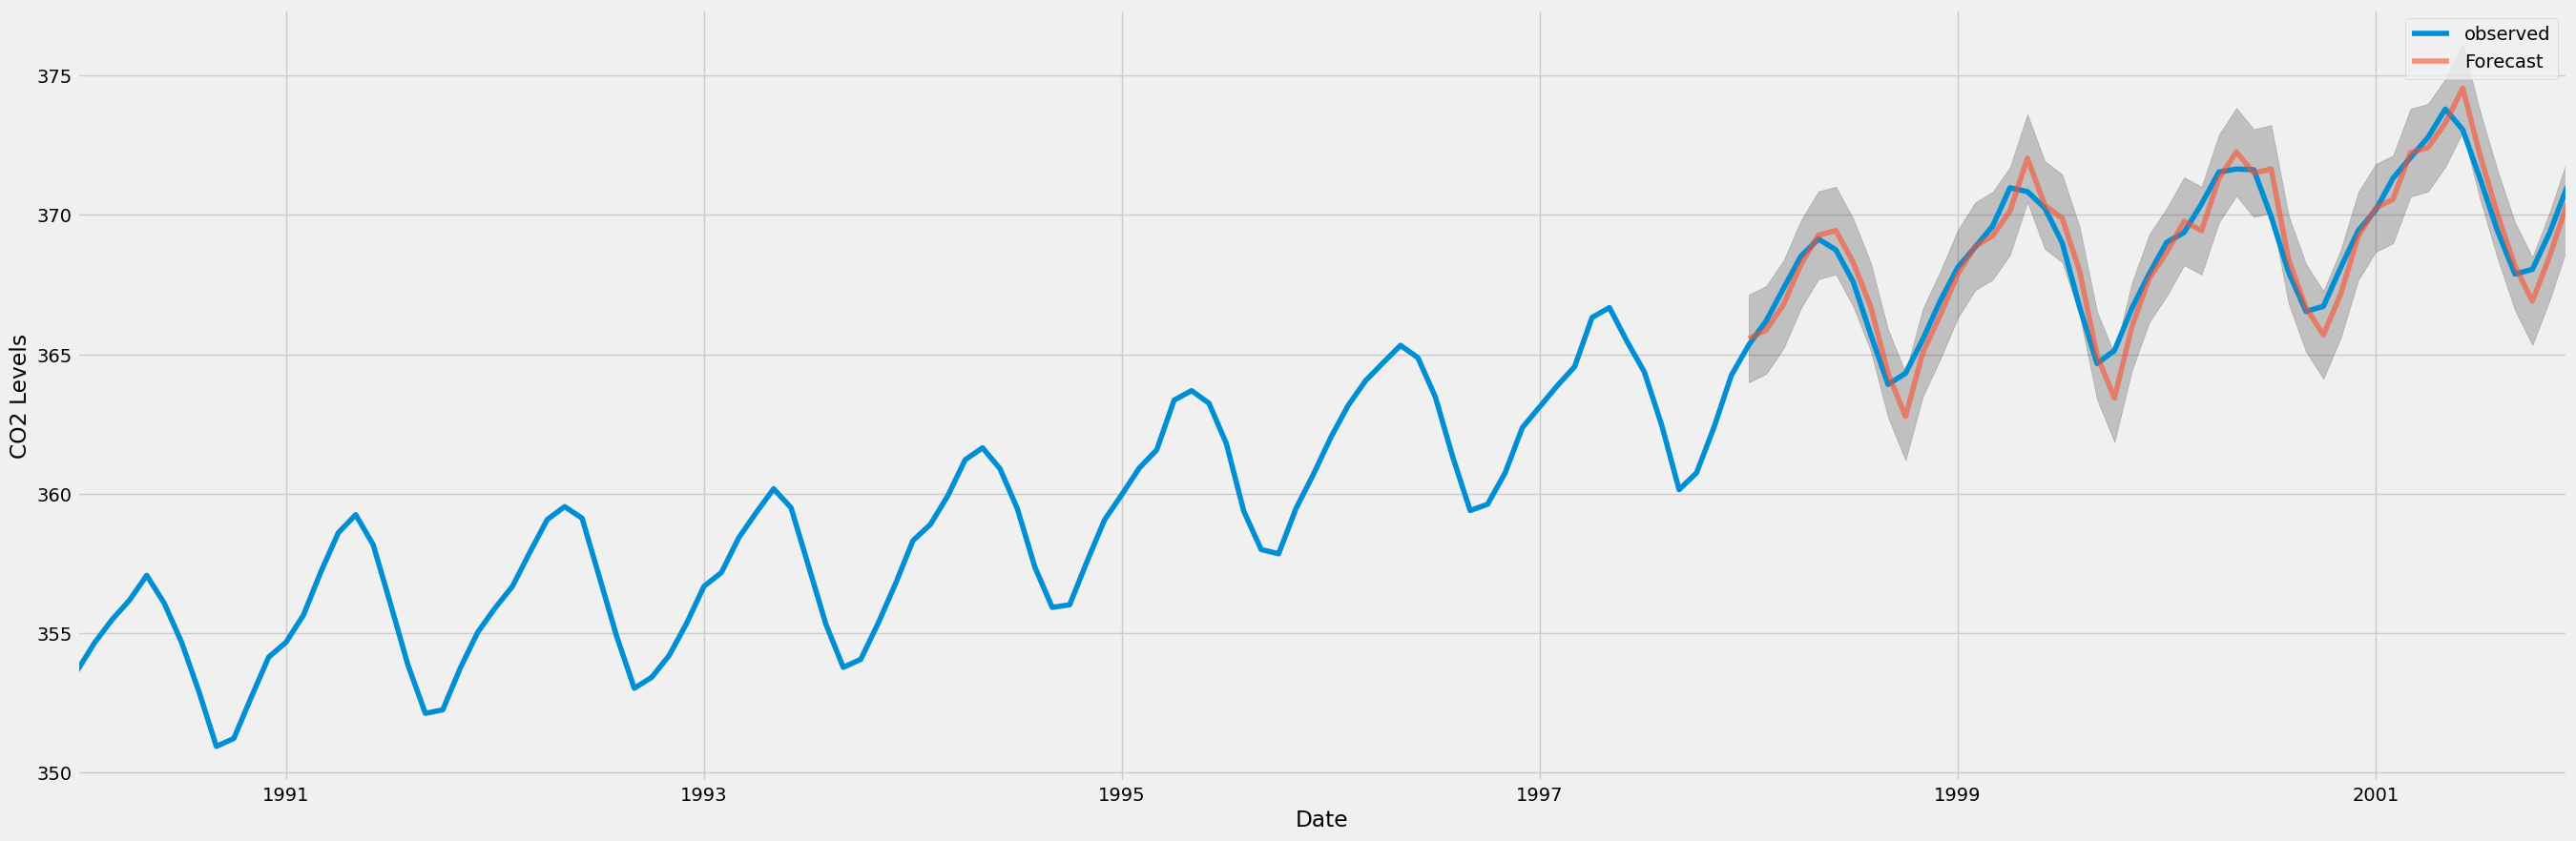

In [ ]:
pred = TSresults.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()
#Returns the confidence interval of the fitted parameters. 

ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.6)

ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()


In [ ]:
pred_ci

,lower co2,upper co2
date,,
1998-01-01,363.993241,367.143395
1998-02-01,364.302464,367.452618
1998-03-01,365.221551,368.371705
1998-04-01,366.662383,369.812537
1998-05-01,367.698431,370.848585
1998-06-01,367.866606,371.016760
1998-07-01,366.717138,369.867291
1998-08-01,365.137514,368.287667
1998-09-01,362.741923,365.892076


In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))



The Mean Squared Error of our forecasts is 0.57


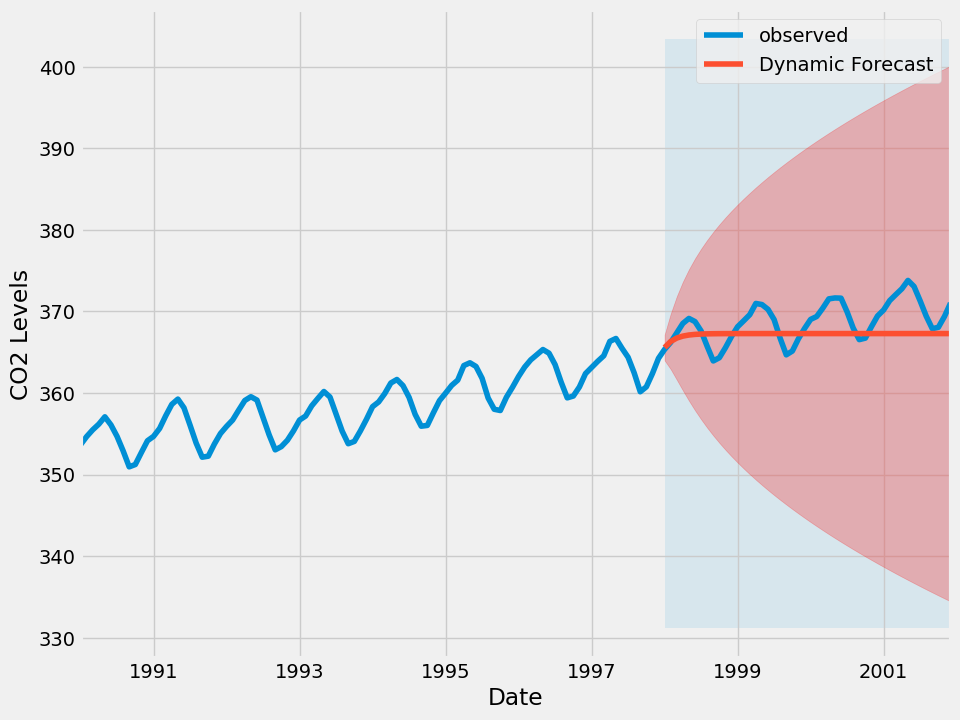

In [ ]:
#pred_dynamic = TSresults.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False, full_results=True)
pred_dynamic = TSresults.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()


ax = y['1990':].plot(label='observed', figsize=(10, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)
ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='r', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()
